# Solving the Advection Equation


### Author

The work is submitted by Yevgeny Menaker (registered as @yev as part of team @quantotto on Aqora platform) for QInnovision World Challenge 2025.

LinkedIn: https://www.linkedin.com/in/yevgeny-menaker-5a2b841/

Email: yev@quantotto.io

In [1]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ExecutionPreferences,
    ClassiqSimulatorBackendNames,
)
from classiq.synthesis import set_execution_preferences
import numpy as np
from matplotlib import pyplot as plt

Below we define hyper-parameters for the quantum program.

In [2]:
n_qbits = 7   # number of qubit to use
t = 1.0       # evolution time
tau = 1.0/32  # time step for trotterization
shots = 4096  # Number of shots to sample

def get_steps(t: float, tau: float) -> int:
    return int(np.floor(t/tau))

## Introduction

In this work, we will be solving Partial Differential Equation governing the fluid dynamics (advection) on a quantum computer. The algorithm will leverage the Hamiltonian simulation after transforming the given advection equation into the Shrödinger one. The work is based on a scientific paper by Yuki Sato et. al "Hamiltonian simulation for hyperbolic partial differential equations by scalable quantum circuits".

The advection equation is of the following form:

$\frac{\partial{\phi}}{\partial{t}}+\frac{\partial{\phi}}{\partial{x}}=0$

with the Dirichlet boundary conditions:

$\phi(0, x)=
\begin{cases}
1, & \text{if } 1 < x < 2\\
0, & \text{otherwise}
\end{cases}
$

Note that the more general form of the advection equation is:

$\frac{\partial{\phi}}{\partial{t}}+U\frac{\partial{\phi}}{\partial{x}}=0$

where $U$ is the fluid speed. In our case, we assume $U=1$. Hence, it is omitted.


The solution is organized in five parts. Part I presents a numeric solution using the classical algorithm to serve as a reference for evaluating the accuracy of quantum results. Part II describes the transformation of advection equation into a Shrödinger form and builds a relevant Hamiltonian. Part III constructs the Classiq based program,  executes the simulation, provides graphical visualization and analyzes the results. Part IV discusses the effciency of the circuit with respect to the CX gates count. Part V summarizes the findings.

## Part I - Classical Solution

Here we present the classical way to solving the advection equation at $t=1.0$. We will disretise the space variable $x$ and the values at each point will be computed iteratively. The approach was inspired by the Julia code in Reference #2.

In [3]:
def phi_0_x(x):
    if 1 < x < 2:
        return 1
    else:
        return 0

n = 2 ** n_qbits
x_axis = np.linspace(0, 4, n)
boundary = [phi_0_x(x) for x in x_axis]


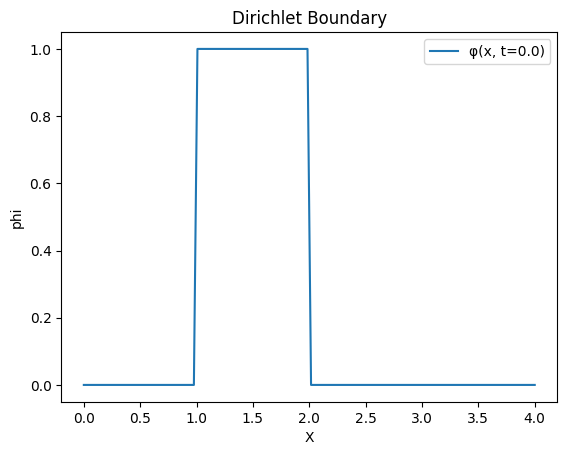

In [4]:
fig, ax = plt.subplots()
ax.plot(x_axis, boundary, label="φ(x, t=0.0)")

ax.set_xlabel("X")
ax.set_ylabel("phi")
ax.legend()

ax.set_title(f"Dirichlet Boundary")
plt.show(block=False)

We need to evolve the initial (boundary) vector representing phi at $t=0$ for a few computational steps till $t=1$

In [5]:
def step(phi: list[float], dt: float, dx: float) -> list[float]:
    new_phi = np.zeros(len(phi))
    for i in range(1, len(phi)-1):
        new_phi[i] = phi[i] - dt * (phi[i+1] - phi[i-1]) / (2*dx)
    return new_phi

def evolve(initial, t, dt, dx):
    phi = initial
    cur_t = dt
    while cur_t <= t:
        phi = step(phi, dt, dx)
        cur_t += dt
    return phi

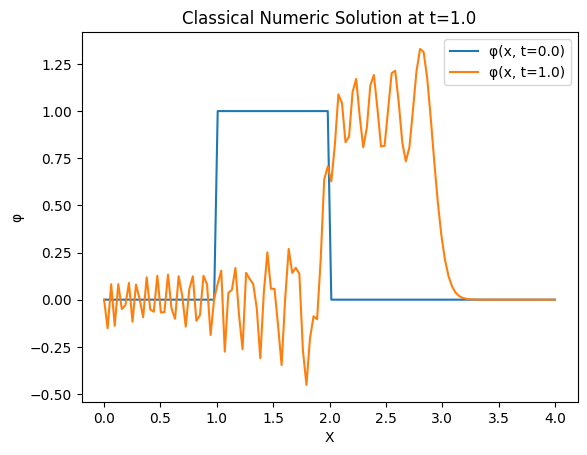

In [6]:
dx = x_axis[1]-x_axis[0]
dt = 0.001
solution = evolve(boundary, t, dt, dx)
fig, ax = plt.subplots()
ax.plot(x_axis, boundary, label="φ(x, t=0.0)")
ax.plot(x_axis, solution, label=f"φ(x, t={t})")

ax.set_xlabel("X")
ax.set_ylabel("φ")
ax.legend()

ax.set_title(f"Classical Numeric Solution at t={t}")
plt.show(block=False)

As we can see in the plot, the particles moved to the right the distance of 1.0 at the time 1.0. This makes sense, because our advection equation assumes $U=1$ (the speed of the fluid; as mentioned in the Introduction section).

Now that we have the reference solution, we will move on to building the quantum algorithm for solving the partial differential equation by means of Hamiltonian simulation.

## Part II - Building Hamiltonian

Our goal is to transform the Advection equation into the Shrödinger form and build the respective Hamiltonian that can be simulated on a quantum computer. The following mathematical steps show the transformation. Note that, like in the scientific paper, we switch to the $\nabla$ operator for the spatial derivative:

$\nabla=\frac{\partial{\phi}}{x}$

Another "trick" that is used is multiplying one side of equation by $-i\cdot-i$.

Here are the steps:

$\frac{\partial{\phi}}{\partial{t}}+\frac{\partial{\phi}}{\partial{x}}=0$

$\frac{\partial{\phi}}{\partial{t}}+\nabla\phi(t, x)=0$

$\frac{\partial{\phi}}{\partial{t}}=-\nabla\phi(t, x)$

$\frac{\partial{\phi}}{\partial{t}}=-i\cdot(-i)\cdot\nabla\phi(t, x)$

And from this, our Hamiltonian is:

$H=(-i)\cdot\nabla$

The $\nabla$ operator can be represented by the central difference discretization $(D^\pm)$:

$H=-i(D^\pm)$

$(D^\pm)_j=\frac{u_{j+1}-u_{j-1}}{2l} for j=0, 1, ..., N-1$

In the next section, we will build a circuit that will evolve the Hamiltonian from time $t=0$ till $t=1$. The initial state is defined by the Dirichlet boundary conditions.

## Part III - Constructing and Executing the Quantum Circuit

Our quantum program will consist of the following high level steps:

- Encoding initial scalar field (as defined by Dirichlet boundary conditions for $\phi(0,x)$ in the Introduction section)
- Evolving the quantum state using the Hamiltonian simulation


While we leverage the technique from the scientific paper, we do introduce a few modifications in terms of choice of gates and also Hamiltonian simulation approximation.

### Initial State

The given advection equation will be solved by the approximated evolution of the Hamiltonian applied to the initial state.

- We divide the $x$ axis $[0, 4]$ into $2^n$ ($n$ is number of qubits) discrete segments of length $l=\frac{1}{2^n}$
- We prepare the initial state having equal amplitudes in $[1, 2]$ and 0 everywhere else

As an example, in case of 7 qubits, we will have 128 segments. Amplitudes 0-31 refer to $\phi(0, x)$ values at $[0, 1)$, 32-63 at $[1, 2)$ etc. So, the Dirichlet boundary for our concrete case of the Advection equation will be expressed by setting the 32-63 amplitudes to be equal $\sqrt{\frac{1}{32}}$ (which means they all have the same probability of $\frac{1}{32}$).



### Time Evolution Operator

The time evolution operator is denoted as $V(\gamma\tau, \lambda)$.
- $\gamma$ is the scaling parameter and it is equal to $\frac{1}{2l}$ for the centrall difference operator, where $l$ is length of a segment
- $\tau$ is the time length of the evolution step and this is our hyper-parameter. After verious tests it was chosen to be $\frac{1}{32}$
- $\lambda$ is the phase parameter. This comes from the fact that the Hamiltonian is based on the Central Difference operator, which is expressed as sum of sums of two shift operators. 

$H = -i(D^\pm) = \sum_{j=1}^{n}(-i)(s^-)_j-(-i)(s^+)_j = \sum_{j=1}^{n}(-i)(s^-)_j+i(s^+)_j$

In the more generic terms used for the derivation of the approximate time evolution operator, each j-th term is expressed as $e^{i\lambda}(s^-)_j+e^{-i\lambda}(s^+)_j$. Hence, we set $e^{i\lambda}=-i$ and $e^{-i\lambda}=i$ for advection equation and we obtain $\lambda=-\frac{\pi}{2}$.

### RY substitution

The scientific paper shows that the forementioned operator $V$ can be expressed as product of $W_j$ operators:

$V=\prod_{j=1}^{n}W_j(\gamma\tau, \lambda)=\prod_{j=1}^{n}W_j(\frac{1}{2l}\cdot\tau, \frac{-\pi}{2})$

The paper shows that each $W_j$ is implemented using the Phase shift, Hadamard and CRZ gates (between a ladder of CNOT gates). We note that in case of Advection equation, we can substitute the hadamard, phase shift and CRZ gates with a single gate CRY. This comes from the fact that the phase $\lambda=-\frac{\pi}{2}$. It doesn't necessarily produce more efficient circuit, but it makes the code more concise. We modified the circuit depicted on FIG. 1 in the paper as shown below.

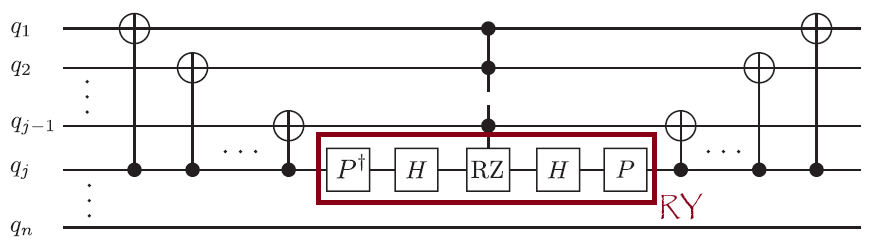

### 2nd Order Approximation

Based on multiple runs and hyper-parameters tuning, we notice that the best results are obtained with the 2nd order approximation described by the equation (44) in the scientific paper.

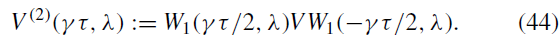

$W_1$ operator doesn't introduce extra CNOT gates because it acts on a single qubit.

### Circuit Code

With the above details in place, we can now implement the circuit using the Classiq platform. We haven't used the specialized `suzuki_trotter` function offered by Classiq, becuase it requires the Hamiltonian argument to be defined in terms of Pauli operators. In case of Advection equation, this would result in the exponential number of terms (more precisely $2^n-1$ Pauli terms). Due to this reason, the "trotterization" was implemented manually.

In [7]:
@qfunc
def u(qbits: QArray[QBit], j: CInt):
    # CNOT ladder
    repeat(count=j, iteration=lambda i: CX(qbits[j], qbits[i]))

@qfunc
def controlled_rotate(control_qbits: QArray[QBit], target: QBit, dt: CReal):
    control(ctrl=control_qbits, stmt_block=lambda: RY(2*dt, target))

@qfunc
def step(qbits: QArray[QBit], j: CInt, dt: CReal):
    within_apply(
        within=lambda: u(qbits, j),
        apply=lambda: controlled_rotate(qbits[0:j], qbits[j], dt)
    )

@qfunc
def ladder(qbits: QArray[QBit], dt: CReal):
    """Use second order approximation
    """
    # W1(-$\tau$/2)
    RY(-dt, qbits[0])

    # V
    RY(2*dt, qbits[0])
    repeat(count=qbits.len-1, iteration=lambda i: step(qbits[0:i+2], i+1, dt))
    
    # W1($\tau$/2)
    RY(dt, qbits[0])

def model_factory(n_qbits: int, t: CReal, tau: CReal) -> QCallable:
    steps = get_steps(t, tau)
    initial = np.zeros(2**n_qbits)
    domain_length = 4
    segment_one = 2**n_qbits // domain_length
    l = 1 / segment_one
    initial[segment_one:2*segment_one] = np.sqrt(1/segment_one)

    @qfunc
    def main(qbits: Output[QArray[n_qbits]]):
        prepare_amplitudes(amplitudes=initial.tolist(), bound=0.01, out=qbits)
        repeat(count=steps, iteration=lambda i: ladder(qbits, t/(2*l)/steps))

    return main

`create_program` function synthesizes the quantum program for a given set of hyper-parameters and evolution time $t$.

In [8]:
async def create_program(n_qbits: int, t: float, tau: float, factory: callable=model_factory):
    backend_preferences = ClassiqBackendPreferences(backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR)
    model = create_model(factory(n_qbits, t, tau))
    model = set_execution_preferences(
        model,
        execution_preferences=ExecutionPreferences(
            num_shots=shots, backend_preferences=backend_preferences
        ),
    )
    qprog = await synthesize_async(model)
    return qprog

`solve` function puts it all together and executes the Quantum Program returning both the result and the synthesized program (to allow circuit analysis).

In [9]:
async def solve(n_qbits: int, t: float, tau: float, factory: callable=model_factory):
    qprog = await create_program(n_qbits, t, tau, factory)
    result = await execute_async(qprog)
    return (await result.result_async())[0].value.model_dump(), qprog

Here we obtain the solution for time $t$ and also display basic information about the circuit (width, depth and CX gates count).

The solution is extracted from counts of each state dividing by number of shots and multiplying by the appropriate scaling factor.

We use 7 qubits, $\tau=\frac{1}{32}$ and 4096 shots (configured in the beginning of the Notebook).

In [10]:
r, qprog_t_1 = await solve(n_qbits, t, tau)
circuit = QuantumProgram.from_qprog(qprog_t_1)
width = circuit.data.width
depth = circuit.transpiled_circuit.depth
cx_count = circuit.transpiled_circuit.count_ops["cx"]
print(f"width={width}\ndepth={depth}\ncx count={cx_count}")

position = np.linspace(0.0, 4.0, 2 ** n_qbits)
states = [f"{i:0{n_qbits}b}" for i in range(2 ** n_qbits)]
scale = ((2 ** n_qbits) // 4)
quantum_solution = [scale*(r["counts"].get(state, 0)/shots) for state in states]

width=9
depth=15789
cx count=10750


We are now ready to plot the solution. The resulting function $\phi(x, t=1.0)$ is shown below.

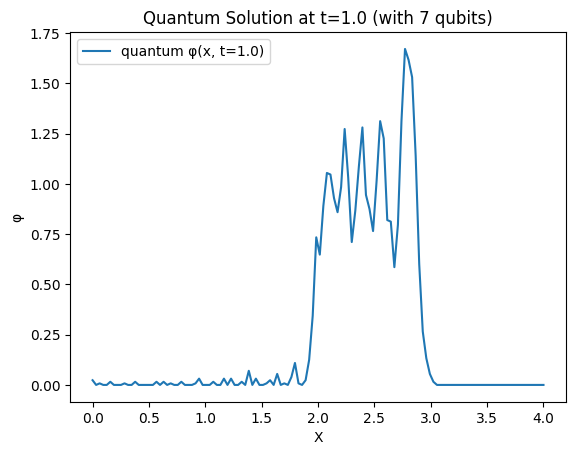

In [11]:
fig, ax = plt.subplots()
ax.plot(position, quantum_solution, label=f"quantum φ(x, t={t})")

ax.set_xlabel("X")
ax.set_ylabel("φ")
ax.legend()

ax.set_title(f"Quantum Solution at t={t} (with {n_qbits} qubits)")
plt.show(block=False)

Here we plot the initial state and two solutions (classical and quantum) side by side to show a significant overlap. Quantum solution doesn't suffer from the oscillations outside of the [2.0, 3.0] segment like the classical numeric one.

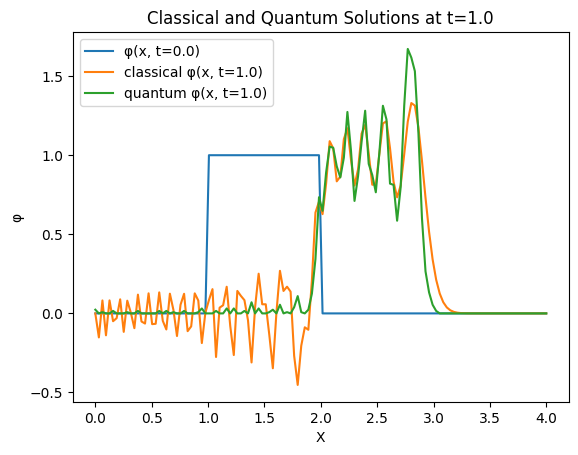

In [12]:
fig, ax = plt.subplots()
ax.plot(position, boundary, label="φ(x, t=0.0)")
ax.plot(position, solution, label=f"classical φ(x, t={t})")
ax.plot(position, quantum_solution, label=f"quantum φ(x, t={t})")

ax.set_xlabel("X")
ax.set_ylabel("φ")
ax.legend()

ax.set_title(f"Classical and Quantum Solutions at t={t}")
plt.show(block=False)

## Part IV - CX Gates Count Analysis

Let us now look at the CX gates count for various values of evolution time $t$.

Here we create a few functions to facilitate the CX count calculation (either extracting from Quantum Program or calculating based on the scientific paper formula).

In [13]:
def count_cx_ops_in_qprog(qprog) -> int:
    circuit = QuantumProgram.from_qprog(qprog)
    return circuit.transpiled_circuit.count_ops["cx"]

async def count_cx_ops(n_qbits: int, t: float, tau: float) -> int:
    qprog = await create_program(n_qbits, t, tau)
    return count_cx_ops_in_qprog(qprog)

def count_cx_theory(n_qbits: int, t: float, tau: float) -> int:
    steps = get_steps(t, tau)
    return steps*((9*(n_qbits**2)) - (33*n_qbits) + 34)

Here we extract the CX gates count from the quantum program we executed above for $t=1$ and compare it with paper prediction.

In [14]:
classiq_cx_count = count_cx_ops_in_qprog(qprog_t_1)
paper_cx_estimation = count_cx_theory(n_qbits, t, tau)
print(f"Classiq CX count: {classiq_cx_count}; Paper CX estimation: {paper_cx_estimation}")

Classiq CX count: 10750; Paper CX estimation: 7808


Now, we can calculate the CX counts for different values of evolution time $t$. Below we do that for $t=0.5, 1.0, 1.5, 2.0$ and plot the results.

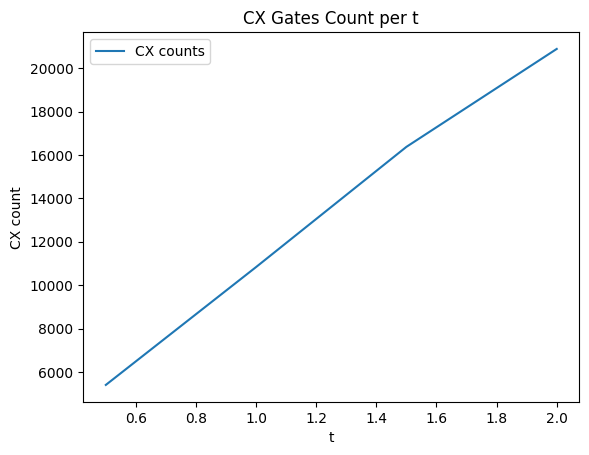

In [15]:
times = np.linspace(0.5, 2.0, 4)
cx_counts = [await count_cx_ops(n_qbits, t_, tau) for t_ in times]

fig, ax = plt.subplots()
ax.plot(times, cx_counts, label="CX counts")

ax.set_xlabel("t")
ax.set_ylabel("CX count")
ax.legend()

ax.set_title(f"CX Gates Count per t")
plt.show(block=False)

It is also beneficial to plot it against the values predicted in the paper. Additionally, we calculate the ratio of Classiq CX gates and paper predicted counts.

In [16]:
paper_cx_counts = [count_cx_theory(n_qbits, t_, tau) for t_ in times]
ratio = [cx_counts[i]/paper_cx_counts[i] for i in range(len(times))]

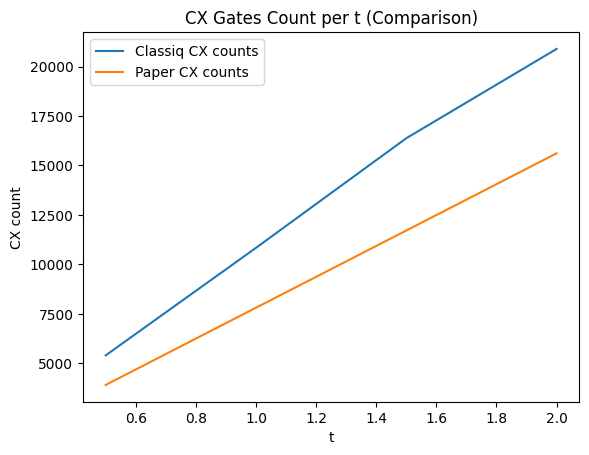

In [17]:
fig, ax = plt.subplots()
ax.plot(times, cx_counts, label="Classiq CX counts")
ax.plot(times, paper_cx_counts, label="Paper CX counts")

ax.set_xlabel("t")
ax.set_ylabel("CX count")
ax.legend()

ax.set_title(f"CX Gates Count per t (Comparison)")
plt.show(block=False)

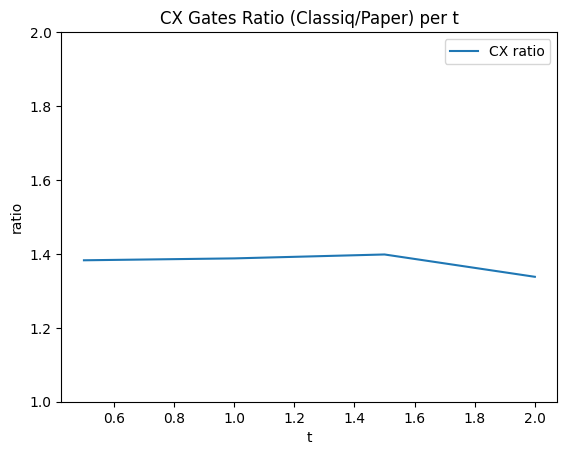

In [18]:
fig, ax = plt.subplots()
ax.plot(times, ratio, label="CX ratio")

ax.set_ylim(1, 2)
ax.set_xlabel("t")
ax.set_ylabel("ratio")
ax.legend()

ax.set_title(f"CX Gates Ratio (Classiq/Paper) per t")
plt.show(block=False)

The number of CX in the Classiq's generated circuit is slightly more than projected by the scientific paper. As we can see from the plot above the ratio `classiq_cx/paper_cx` is close to $1.4$.

Below we explain the discrepancy.

The paper predicts $16*n-40$ CX gates for CRZ decomposition, but Classiq's one is sometimes bigger as calculated below. Also, note that synthesizing the same circuit may produce different results in terms of CX gates count from run to run.

In [19]:
qbits_range = list(range(2, n_qbits+1))
async def count_cx_for_cry(n: CInt) -> int:
    @qfunc
    def main(control_qbits: Output[QArray], target: Output[QBit]):
        allocate(n-1, control_qbits)
        allocate(1, target)
        hadamard_transform(control_qbits)
        X(target)
        control(ctrl=control_qbits, stmt_block=lambda: RY(np.pi/4, target))

    my_model = create_model(main)
    my_qprog = await synthesize_async(my_model)
    circuit = QuantumProgram.from_qprog(my_qprog)
    return circuit.transpiled_circuit.count_ops["cx"]

cx_counts_for_cry = { qbits: (await count_cx_for_cry(qbits), 16*qbits - 40 if qbits > 2 else 2) for qbits in qbits_range }
print(f"CX count for CRY:")
for qbits, counts in cx_counts_for_cry.items():
    print(f"[{qbits} qubits] classiq's count: {counts[0]}; paper prediction: {counts[1]}")



CX count for CRY:
[2 qubits] classiq's count: 2; paper prediction: 2
[3 qubits] classiq's count: 12; paper prediction: 8
[4 qubits] classiq's count: 18; paper prediction: 24
[5 qubits] classiq's count: 24; paper prediction: 40
[6 qubits] classiq's count: 106; paper prediction: 56
[7 qubits] classiq's count: 168; paper prediction: 72


Graphically, the comparison will look as below.

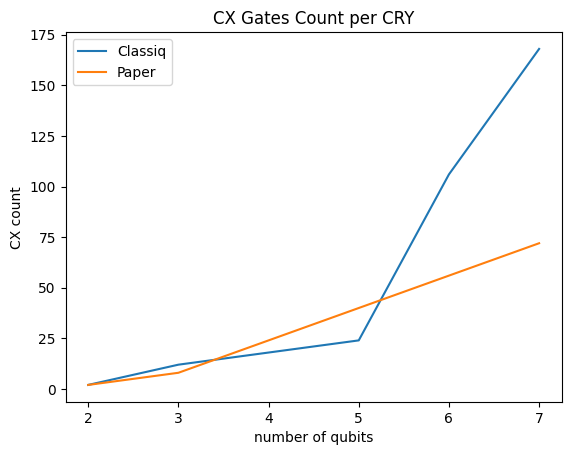

In [20]:
fig, ax = plt.subplots()
ax.plot(qbits_range, cx_counts_for_cry.values(), label=("Classiq", "Paper"))

ax.set_xlabel("number of qubits")
ax.set_ylabel("CX count")
ax.set_xticks(qbits_range)
ax.legend()

ax.set_title(f"CX Gates Count per CRY")
plt.show(block=False)

Based on this, it makes sense that we are getting higher counts of CX gates from the Classiq platform.

## Part V - Summary

In this work, we focused on implementing the algorithm solving the Advection Equation by means of Hamiltonian simulation relying on the technique from the scientific paper (Reference 1). We have designated several hyper-parameters to tune the model and also analyzed the resulting CX gates count for different inputs. We ended up using the 2nd order Trotter Approximation. It results in a more accurate differential equation solution without higher CX gates count.

We found the ration of ~1.4 for $\frac{CX(Classiq)}{CX(Paper)}$.

We opted for making the following choice of hyper-parameters:
- 7 qubits
- 4096 shots
- $\frac{1}{32}$ as the time step for approximate evolution of Hamiltonian

One of the future directions to explore would be looking at 1-sparse Hamiltonian simulation as well as more tuning of hyper-parameters and analyzing the resulting circuits' depth and CX gates count.

## References

1. ["Hamiltonian simulation for hyperbolic partial differential equations by scalable quantum circuits"](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.6.033246) Physical Review Research 6.3 (2024): 033246 by Sato, Yuki, et al. 
2. ["Evolution in time and space: Advection and diffusion in 1D"](https://computationalthinking.mit.edu/Fall24/climate_science/advection_and_diffusion/), Introduction to Computational Thinking course at MIT by by Alan Edelman, David P. Sanders & Charles E. Leiserson 